In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import FinanceDataReader as fdr
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

from sklearn.preprocessing import StandardScaler
from neuralprophet import NeuralProphet

%matplotlib inline
warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.


In [10]:
stock = fdr.DataReader('041930', '2015')
stock['y'] = stock['Close']
stock['ds'] = stock.index
stock['mid'] = (stock['Low'] + stock['High'])*0.5
df = pd.DataFrame({'y':stock['mid'], 'ds':stock.index})
df

,y,ds
Date,,
2015-01-02,5495.0,2015-01-02
2015-01-05,5570.0,2015-01-05
2015-01-06,5620.0,2015-01-06
2015-01-07,5570.0,2015-01-07
2015-01-08,5555.0,2015-01-08
...,...,...
2021-06-23,15000.0,2021-06-23
2021-06-24,14725.0,2021-06-24
2021-06-25,14550.0,2021-06-25


In [231]:
# 표준화 작업하는거(필요하면 해보고 아님 말고)
scaler = StandardScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['y']
# 스케일 후 columns
scaled = scaler.fit_transform(stock[scale_cols])
df = pd.DataFrame(scaled, columns=scale_cols)
df['ds'] = stock.index

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


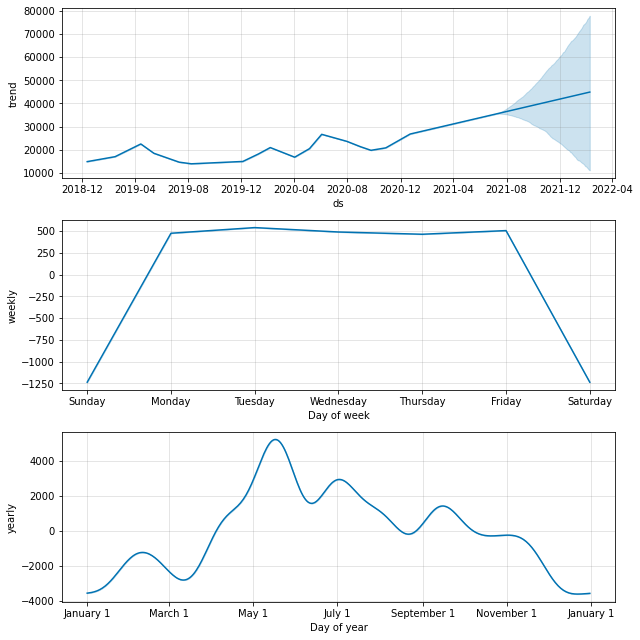

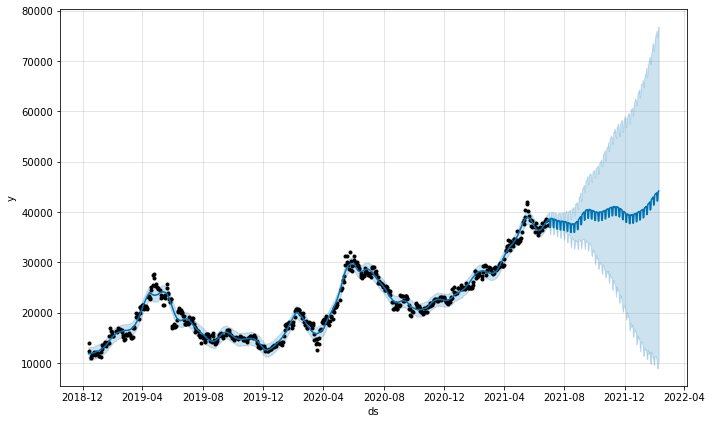

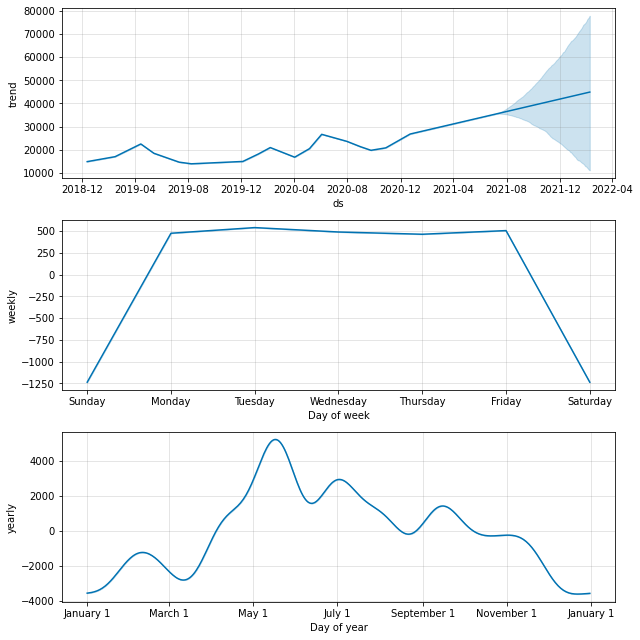

In [4]:
#fbprophet를 이용해서 하는거

m = Prophet(changepoint_prior_scale=0.5)
m.fit(stock)
future = m.make_future_dataframe(periods=224)
forecast = m.predict(future)
m.plot(forecast)
m.plot_components(forecast)

In [5]:
# NeuralProphet를 이용해서 하는거

model = NeuralProphet(n_changepoints=100, trend_reg=0.5, 
                     yearly_seasonality = True,
                     weekly_seasonality = False,
                     daily_seasonality = False)
metrics = model.fit(df, validate_each_epoch=True, 
                    valid_p=0.2, freq='D', 
                    plot_live_loss=True, epochs=100)

INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO:nprophet.config:Note: Trend changepoint regularization is experimental.
Traceback (most recent call last):
  File "/Users/singyeongseob/opt/anaconda3/envs/pp379/lib/python3.7/site-packages/neuralprophet/forecaster.py", line 585, in _train
    from livelossplot import PlotLosses
ModuleNotFoundError: No module named 'livelossplot'
Traceback (most recent call last):
  File "/Users/singyeongseob/opt/anaconda3/envs/pp379/lib/python3.7/site-packages/neuralprophet/forecaster.py", line 585, in _train
    from livelossplot import PlotLosses
ModuleNotFoundError: No module named 'livelossplot'
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.23E-01
INFO:nprophet:learning rate range test found optimal lr: 1.23E-01
Epoch[100/100]: 100%|██████████| 100/100 [00:16<00:00,  5.91it/s, SmoothL1Loss=0.00313, MAE=1.15e+3, RegLoss=0.0156, MAE_val=2.18e+3, SmoothL1Loss_val=0.0135]


In [6]:
# 예측하고 그래프 그리는 함수

def plot_forecast(model, data, periods, historic_pred=True, highlight_steps_ahead=None):
    
    future = model.make_future_dataframe(data, 
                                         periods=periods, 
                                         n_historic_predictions=historic_pred)
    forecast = model.predict(future)
    
    if highlight_steps_ahead is not None:
        model = model.highlight_nth_step_ahead_of_each_forecast(highlight_steps_ahead)
        model.plot_last_forecast(forecast)
    else:    
        model.plot(forecast)

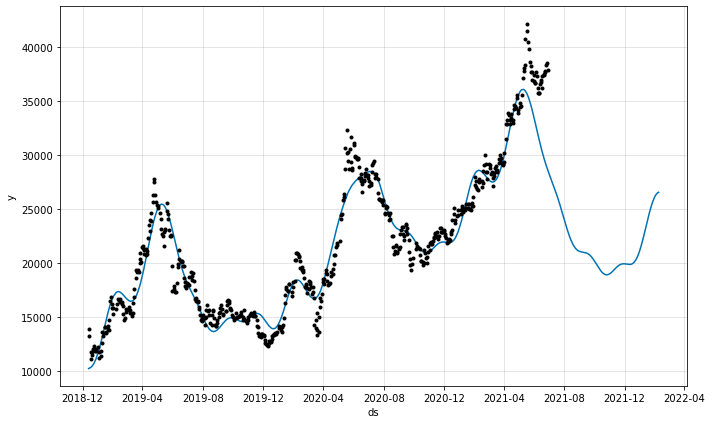

In [7]:
plot_forecast(model, df, periods=224, historic_pred=True)

In [11]:
# 휴일을 추가하고 배치사이즈를 좀더 늘려고 해봄 epoch도 늘려봄

model = NeuralProphet(
    n_forecasts=60,
    n_lags=60,
    changepoints_range=0.95,
    n_changepoints=100,
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    batch_size=64,
    epochs=200,
    learning_rate=1.0,
)

model = model.add_country_holidays("KR", mode="additive", lower_window=-1, upper_window=1)

model.fit(df, 
          freq='D',
          valid_p=0.2,
          epochs=100)

INFO: nprophet - _handle_missing_data: 774 missing dates were added.
INFO:nprophet:774 missing dates were added.
INFO: nprophet - _handle_missing_data: 774 NaN values in column y were auto-imputed.
INFO:nprophet:774 NaN values in column y were auto-imputed.
Epoch[100/100]: 100%|██████████| 100/100 [00:51<00:00,  1.93it/s, SmoothL1Loss=0.00135, MAE=331, RegLoss=0] 


,SmoothL1Loss,MAE,RegLoss
0,0.176430,4309.336111,0.0
1,0.028627,1720.169523,0.0
2,0.009758,980.668276,0.0
3,0.006027,748.868473,0.0
4,0.004545,638.818830,0.0
...,...,...,...
95,0.001371,332.136842,0.0
96,0.001372,335.539089,0.0
97,0.001359,334.077196,0.0
98,0.001355,330.359167,0.0


INFO: nprophet - _handle_missing_data: 774 missing dates were added.
INFO:nprophet:774 missing dates were added.
INFO: nprophet - _handle_missing_data: 774 NaN values in column y were auto-imputed.
INFO:nprophet:774 NaN values in column y were auto-imputed.


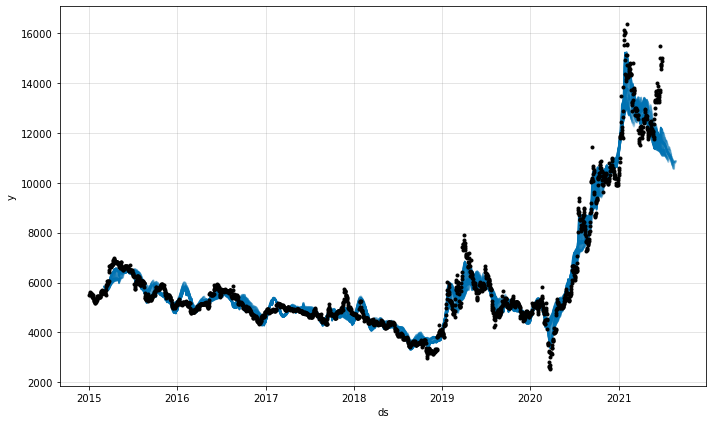

In [19]:
plot_forecast(model, df, periods=60, historic_pred=True)